In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention, CrossAttention
import sys,os
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
dnf300 = pd.read_json('evaluation_set/deepnofakes/dnf_300/combined_300.json').T
dnf_eval = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V4.json')
# display(dnf_eval.head(2))
dnf_eval.columns = ['authors','claim_ids', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf300.keys(), len(articles.keys()), len(article_vectors.keys())

(Index(['authors', 'claim_ids', 'evidence', 'headline', 'id', 'reason',
        'claims', 'type', 'urls'],
       dtype='object'),
 Index(['authors', 'evidence', 'headline', 'id', 'reason', 'type', 'urls'], dtype='object'),
 300,
 300)

In [4]:
num_splits = 5
kf = KFold(n_splits=num_splits)
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 2000
max_sentences = 500
# for idx in articles.keys():
#     num = len(articles[idx])
#     if num>=max_sentences:
#         max_sentences = num
        
max_sentences

500

In [5]:
titles = sorted(dnf300.headline.unique())
len(titles)

300

In [6]:
test_titles = sorted(dnf_eval.headline.unique())

In [7]:
titles = sorted(dnf300.headline.unique())
non_test_titles = np.array(list(set(titles)-set(test_titles)))


In [8]:
indices = []
for train_index, val_index in kf.split(non_test_titles):
    indices.append([train_index,val_index])

In [9]:

train_index, val_index = indices[np.random.randint(0,num_splits)]
print(train_index,val_index)
val_titles = non_test_titles[val_index]
train_titles = non_test_titles[train_index]
len(train_titles),len(val_titles),len(test_titles)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248
 249 250 251 252] [ 51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94 

(202, 51, 50)

In [10]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [11]:

def datagen_dnf(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        idx = idx.strip()
        
            
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        if mode=='test':
            hd = dnf_eval[dnf_eval.headline==idx]['headline'].values[0].lower()
            ar_id = dnf_eval[dnf_eval.headline==idx]['id'].values[0]
            cl = dnf_eval[dnf_eval.headline==idx]['claim_ids'].values[0]
            ar_claims.append(cl)
            
        else:
            try:
                hd = dataframe[dataframe.headline==idx]['headline'].values[0].lower()
                ar_id = dataframe[dataframe.headline==idx]['id'].values[0]
                ar_claims.append('None')
            except Exception as ex:
                print(ex)
                print(idx)
        sentences = articles[ar_id]
        vectors = article_vectors[ar_id]
        hds.append(hd)
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
 

In [12]:
tdg = datagen_dnf(train_batchsize,dnf300,mode='train')
vdg = datagen_dnf(val_batchsize,dnf300,mode='val')
test_dg = datagen_dnf(test_batchsize,dnf300,mode='test')

In [13]:
x,y = next(test_dg)

In [14]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 500, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 500, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

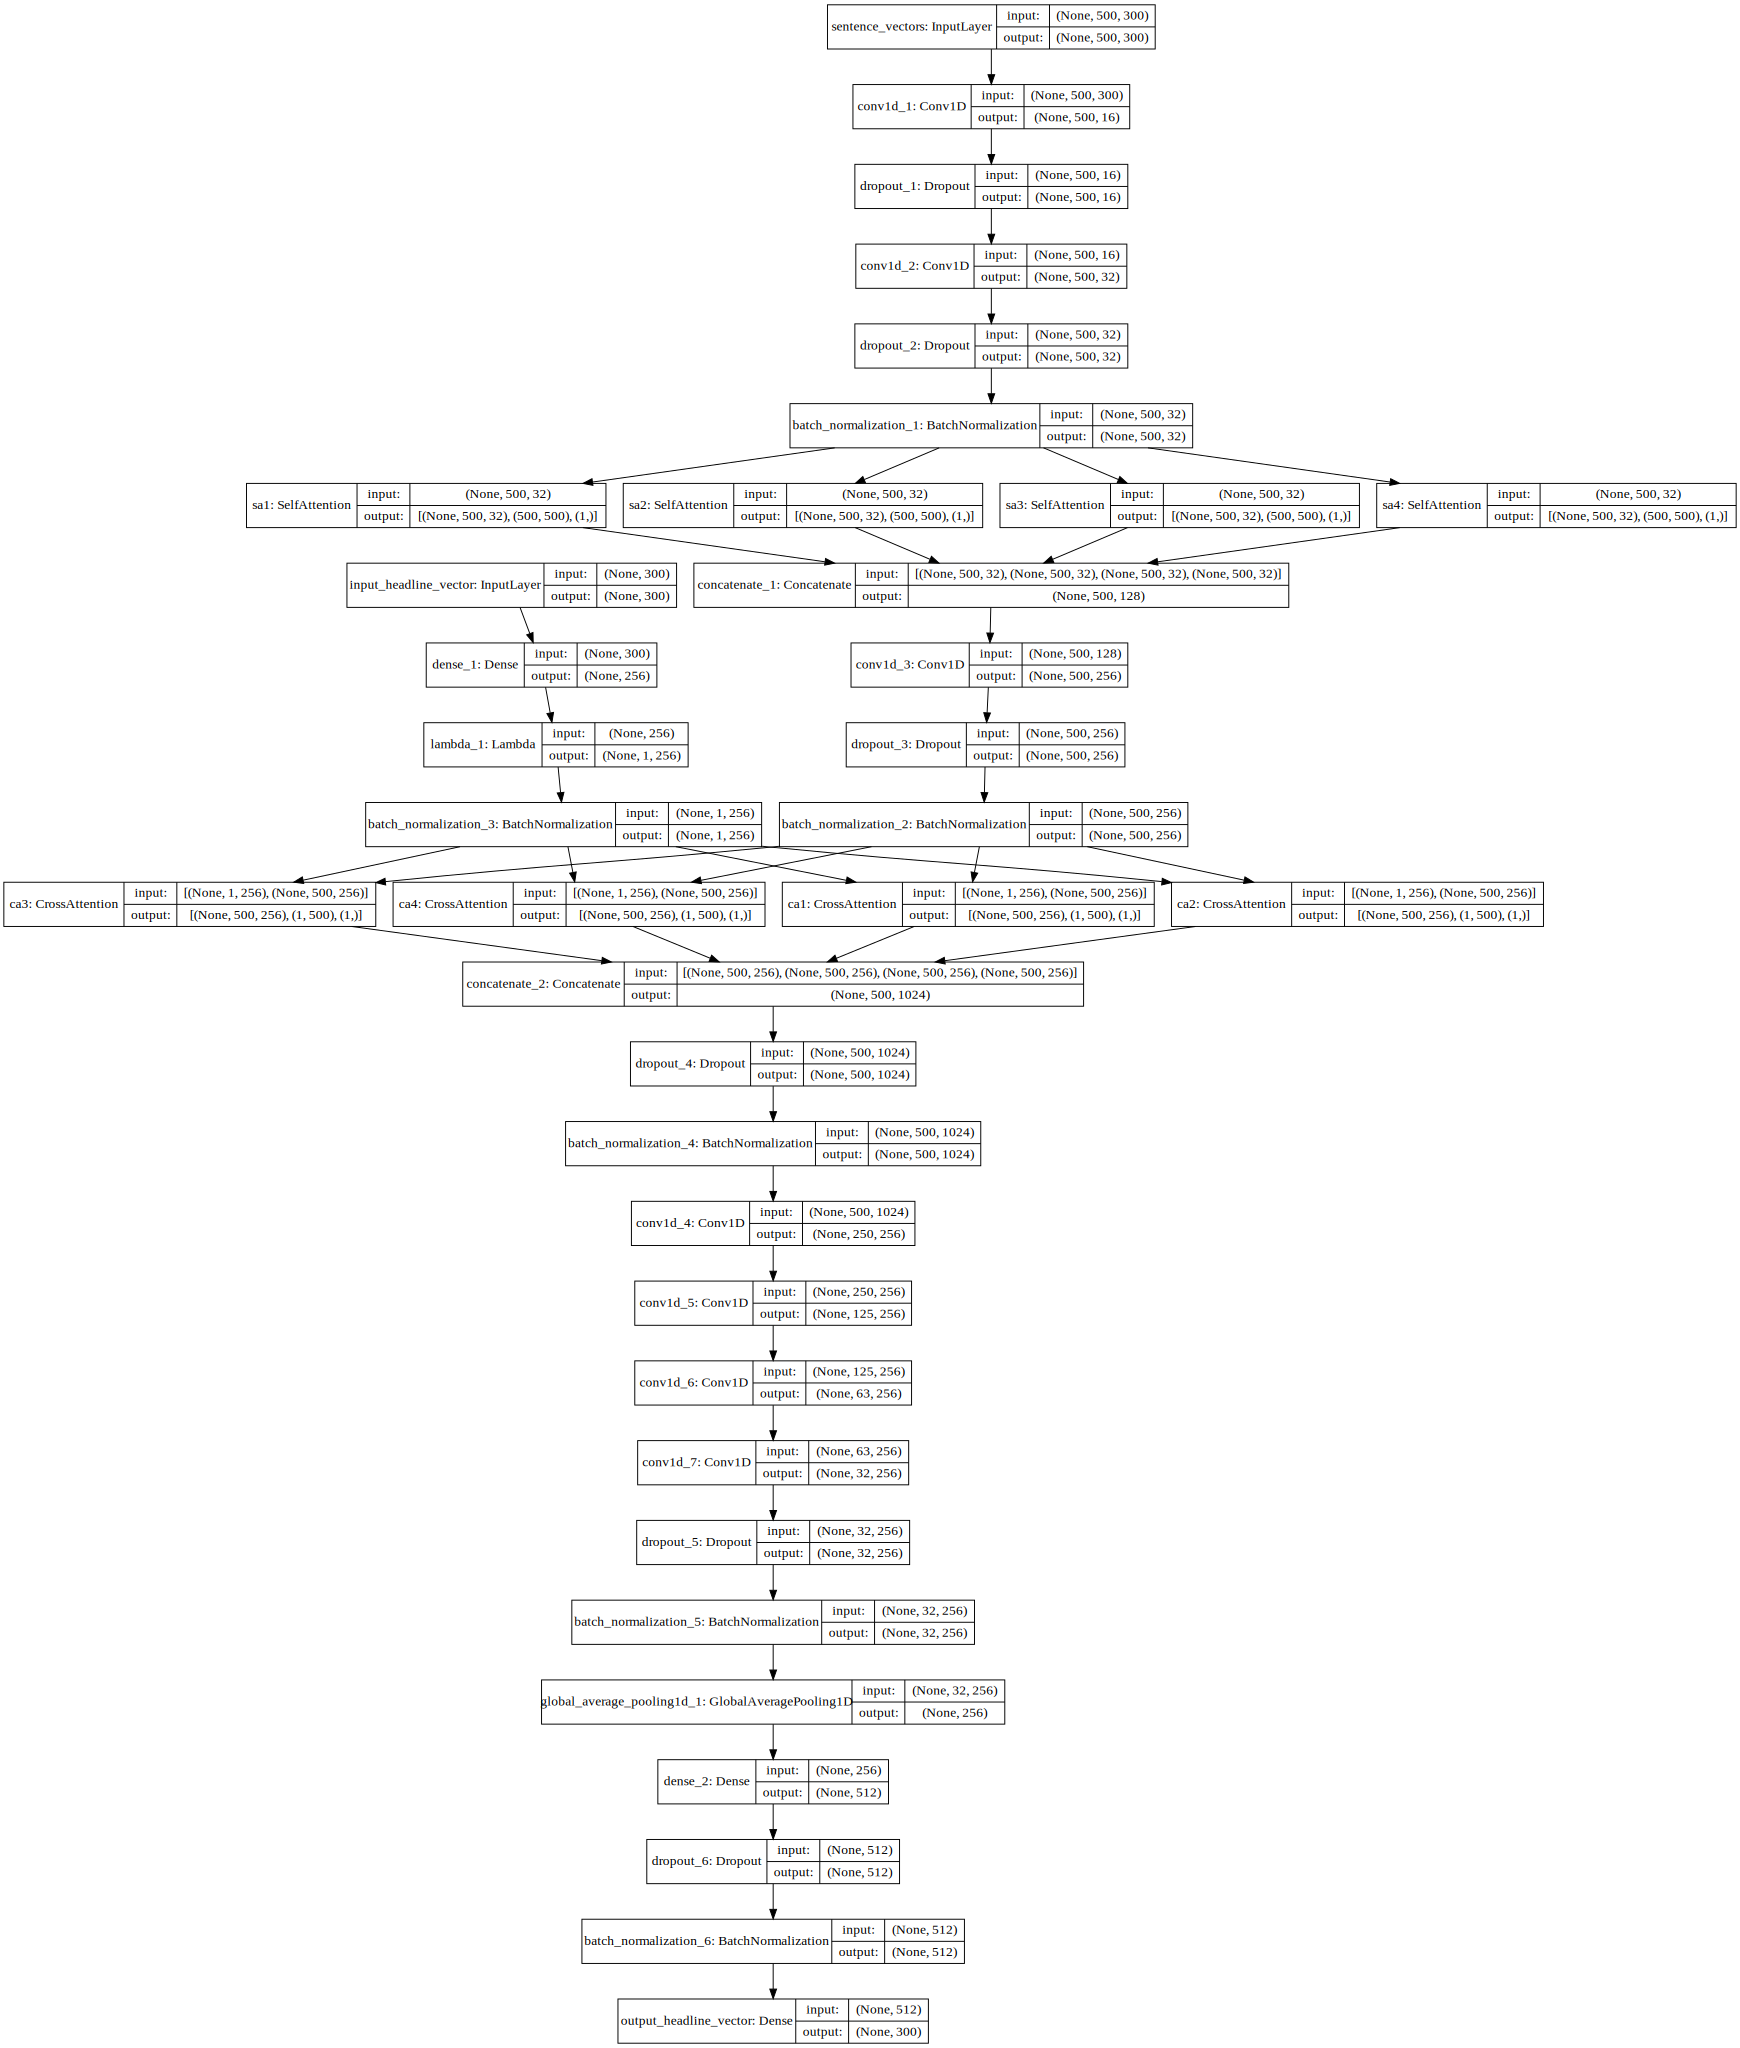

In [15]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]), name = 'sa1')(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]), name = 'sa2')(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]), name = 'sa3')(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]), name = 'sa4')(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
#     repeat = RepeatVector(50)(gap)
#     lstm = LSTM(256,return_sequences=True)(repeat)
    dense1 = Dense(512,activation='relu')(gap)
    dense1 = Dropout(0.5)(dense1)
    dense1 = BatchNormalization()(dense1)
    gen_hd_vector = Dense(300,activation='linear', name='output_headline_vector')(dense1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='mse')
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [16]:
dt = datetime.now()
mc = ModelCheckpoint('weights/dnf300_sa_sent_hd_vector_gl.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/dnf300_sa_sent_hd_vector_gl/{0}'.format(dt.timestamp()),write_graph=True)

In [17]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 1/2000
4/4 [==============================] - 18s 4s/step - loss: 1.1858 - val_loss: 0.4229
Epoch 2/2000
4/4 [==============================] - 0s 119ms/step - loss: 1.1558 - val_loss: 0.3670
Epoch 3/2000
4/4 [==============================] - 0s 114ms/step - loss: 1.1311 - val_loss: 0.3372
Epoch 4/2000
4/4 [==============================] - 2s 567ms/step - loss: 1.1232 - val_loss: 0.3229
Epoch 5/2000
4/4 [==============================] - 5s 1s/step - loss: 1.1230 - val_loss: 0.2967
Epoch 6/2000
4/4 [==============================] - 5s 1s/step - loss: 1.1249 - val_loss: 0.2740
Epoch 7/2000
4/4 [==============================] - 4s 1s/step - loss: 1.1159 - val_loss: 0.2751
Epoch 8/2000
4/4 [==============================] - 5s 1s/step - loss: 1.0970 - val_loss: 0.2692
Epoch 9/2000
4/4 [==============================] - 4s 1s/step - loss: 1.0911 - val_loss: 0.2675
Epoch 10/2000
4/4 [==============================] - 5s 1s/step - loss: 1.0976 - val_loss: 0.2602
Epoch 11/2000
4/4 [

4/4 [==============================] - 11s 3s/step - loss: 0.1055 - val_loss: 0.0172
Epoch 167/2000
4/4 [==============================] - 12s 3s/step - loss: 0.1100 - val_loss: 0.0158
Epoch 168/2000
4/4 [==============================] - 13s 3s/step - loss: 0.1024 - val_loss: 0.0172
Epoch 169/2000
4/4 [==============================] - 12s 3s/step - loss: 0.0936 - val_loss: 0.0147
Epoch 170/2000
4/4 [==============================] - 11s 3s/step - loss: 0.1029 - val_loss: 0.0160
Epoch 171/2000
4/4 [==============================] - 12s 3s/step - loss: 0.0978 - val_loss: 0.0164
Epoch 172/2000
4/4 [==============================] - 12s 3s/step - loss: 0.0970 - val_loss: 0.0150
Epoch 173/2000
4/4 [==============================] - 11s 3s/step - loss: 0.0951 - val_loss: 0.0144
Epoch 174/2000
4/4 [==============================] - 11s 3s/step - loss: 0.0914 - val_loss: 0.0158
Epoch 175/2000
4/4 [==============================] - 11s 3s/step - loss: 0.0930 - val_loss: 0.0159
Epoch 176/2000


4/4 [==============================] - 15s 4s/step - loss: 0.0441 - val_loss: 0.0106
Epoch 249/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0482 - val_loss: 0.0104
Epoch 250/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0462 - val_loss: 0.0112
Epoch 251/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0478 - val_loss: 0.0112
Epoch 252/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0457 - val_loss: 0.0115
Epoch 253/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0469 - val_loss: 0.0090
Epoch 254/2000
4/4 [==============================] - 14s 3s/step - loss: 0.0454 - val_loss: 0.0108
Epoch 255/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0463 - val_loss: 0.0101
Epoch 256/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0452 - val_loss: 0.0117
Epoch 257/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0436 - val_loss: 0.0097
Epoch 258/2000


4/4 [==============================] - 14s 4s/step - loss: 0.0242 - val_loss: 0.0103
Epoch 331/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0267 - val_loss: 0.0113
Epoch 332/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0211 - val_loss: 0.0092
Epoch 333/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0260 - val_loss: 0.0128
Epoch 334/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0241 - val_loss: 0.0105
Epoch 335/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0221 - val_loss: 0.0125
Epoch 336/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0236 - val_loss: 0.0090
Epoch 337/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0229 - val_loss: 0.0123
Epoch 338/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0231 - val_loss: 0.0109
Epoch 339/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0219 - val_loss: 0.0104
Epoch 340/2000


4/4 [==============================] - 14s 4s/step - loss: 0.0106 - val_loss: 0.0103
Epoch 413/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0104 - val_loss: 0.0119
Epoch 414/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0103 - val_loss: 0.0104
Epoch 415/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0115 - val_loss: 0.0106
Epoch 416/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0111 - val_loss: 0.0092
Epoch 417/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0104 - val_loss: 0.0097
Epoch 418/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0111 - val_loss: 0.0097
Epoch 419/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0127 - val_loss: 0.0101
Epoch 420/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0111 - val_loss: 0.0107
Epoch 421/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0111 - val_loss: 0.0103
Epoch 422/2000


4/4 [==============================] - 15s 4s/step - loss: 0.0101 - val_loss: 0.0102
Epoch 495/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0112 - val_loss: 0.0105
Epoch 496/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0108 - val_loss: 0.0108
Epoch 497/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0101 - val_loss: 0.0104
Epoch 498/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0100 - val_loss: 0.0095
Epoch 499/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0100 - val_loss: 0.0092
Epoch 500/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0104 - val_loss: 0.0104
Epoch 501/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0108 - val_loss: 0.0105
Epoch 502/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0110 - val_loss: 0.0121
Epoch 503/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0111 - val_loss: 0.0129
Epoch 504/2000


4/4 [==============================] - 15s 4s/step - loss: 0.0102 - val_loss: 0.2603
Epoch 577/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0119 - val_loss: 0.0812
Epoch 578/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0106 - val_loss: 0.0305
Epoch 579/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0103 - val_loss: 0.0145
Epoch 580/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0100 - val_loss: 0.0112
Epoch 581/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0106 - val_loss: 0.0113
Epoch 582/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0105 - val_loss: 0.0101
Epoch 583/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0114 - val_loss: 0.0118
Epoch 584/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0105 - val_loss: 0.0104
Epoch 585/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0102 - val_loss: 0.0105
Epoch 586/2000


4/4 [==============================] - 15s 4s/step - loss: 0.0108 - val_loss: 0.0097
Epoch 659/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0114 - val_loss: 0.0102
Epoch 660/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0099 - val_loss: 0.0134
Epoch 661/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0111 - val_loss: 0.0101
Epoch 662/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0105 - val_loss: 0.0093
Epoch 663/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0102 - val_loss: 0.0116
Epoch 664/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0108 - val_loss: 0.0089
Epoch 665/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0105 - val_loss: 0.0110
Epoch 666/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0109 - val_loss: 0.0104
Epoch 667/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0111 - val_loss: 0.0112
Epoch 668/2000


4/4 [==============================] - 15s 4s/step - loss: 0.0100 - val_loss: 0.0115
Epoch 741/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0099 - val_loss: 0.0111
Epoch 742/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0106 - val_loss: 0.0112
Epoch 743/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0109 - val_loss: 0.0106
Epoch 744/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0104 - val_loss: 0.0112
Epoch 745/2000
4/4 [==============================] - 13s 3s/step - loss: 0.0107 - val_loss: 0.0099
Epoch 746/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0098 - val_loss: 0.0121
Epoch 747/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0105 - val_loss: 0.0122
Epoch 748/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0103 - val_loss: 0.0117
Epoch 749/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0103 - val_loss: 0.0089
Epoch 750/2000


4/4 [==============================] - 14s 3s/step - loss: 0.0113 - val_loss: 0.0110
Epoch 823/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0105 - val_loss: 0.0095
Epoch 824/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0106 - val_loss: 0.0119
Epoch 825/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0108 - val_loss: 0.0116
Epoch 826/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0104 - val_loss: 0.0111
Epoch 827/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0102 - val_loss: 0.0107
Epoch 828/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0109 - val_loss: 0.0097
Epoch 829/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0098 - val_loss: 0.0097
Epoch 830/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0110 - val_loss: 0.0120
Epoch 831/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0102 - val_loss: 0.0096
Epoch 832/2000


4/4 [==============================] - 15s 4s/step - loss: 0.0107 - val_loss: 0.0104
Epoch 905/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0104 - val_loss: 0.0099
Epoch 906/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0103 - val_loss: 0.0096
Epoch 907/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0097 - val_loss: 0.0104
Epoch 908/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0099 - val_loss: 0.0108
Epoch 909/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0106 - val_loss: 0.0118
Epoch 910/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0115 - val_loss: 0.0103
Epoch 911/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0106 - val_loss: 0.0100
Epoch 912/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0115 - val_loss: 0.0109
Epoch 913/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0109 - val_loss: 0.0102
Epoch 914/2000


4/4 [==============================] - 14s 4s/step - loss: 0.0108 - val_loss: 0.0107
Epoch 987/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0111 - val_loss: 0.0104
Epoch 988/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0110 - val_loss: 0.0112
Epoch 989/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0112 - val_loss: 0.0107
Epoch 990/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0113 - val_loss: 0.0096
Epoch 991/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0106 - val_loss: 0.0117
Epoch 992/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0102 - val_loss: 0.0118
Epoch 993/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0099 - val_loss: 0.0099
Epoch 994/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0105 - val_loss: 0.0103
Epoch 995/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0116 - val_loss: 0.0109
Epoch 996/2000


4/4 [==============================] - 14s 3s/step - loss: 0.0097 - val_loss: 0.0118
Epoch 1149/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0112 - val_loss: 0.0121
Epoch 1150/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0104 - val_loss: 0.0105
Epoch 1151/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0123 - val_loss: 0.0114
Epoch 1152/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0108 - val_loss: 0.0102
Epoch 1153/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0108 - val_loss: 0.0102
Epoch 1154/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0107 - val_loss: 0.0105
Epoch 1155/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0109 - val_loss: 0.0094
Epoch 1156/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0105 - val_loss: 0.0101
Epoch 1157/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0105 - val_loss: 0.0094
Epoch 

4/4 [==============================] - 15s 4s/step - loss: 0.0106 - val_loss: 0.0112
Epoch 1311/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0100 - val_loss: 0.0126
Epoch 1312/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0103 - val_loss: 0.0113
Epoch 1313/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0115 - val_loss: 0.0106
Epoch 1314/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0107 - val_loss: 0.0115
Epoch 1315/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0102 - val_loss: 0.0111
Epoch 1316/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0100 - val_loss: 0.0104
Epoch 1317/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0100 - val_loss: 0.0100
Epoch 1318/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0116 - val_loss: 0.0114
Epoch 1319/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0110 - val_loss: 0.0113
Epoch 

4/4 [==============================] - 14s 4s/step - loss: 0.0106 - val_loss: 0.4837
Epoch 1473/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0109 - val_loss: 0.0426
Epoch 1474/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0104 - val_loss: 0.0130
Epoch 1475/2000
4/4 [==============================] - 14s 3s/step - loss: 0.0104 - val_loss: 0.0106
Epoch 1476/2000
4/4 [==============================] - 14s 3s/step - loss: 0.0109 - val_loss: 0.0113
Epoch 1477/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0103 - val_loss: 0.0114
Epoch 1478/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0105 - val_loss: 0.0108
Epoch 1479/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0114 - val_loss: 0.0112
Epoch 1480/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0111 - val_loss: 0.0105
Epoch 1481/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0111 - val_loss: 0.0113
Epoch 

4/4 [==============================] - 14s 3s/step - loss: 0.0113 - val_loss: 0.0128
Epoch 1635/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0101 - val_loss: 0.0100
Epoch 1636/2000
4/4 [==============================] - 13s 3s/step - loss: 0.0113 - val_loss: 0.0097
Epoch 1637/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0099 - val_loss: 0.0106
Epoch 1638/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0105 - val_loss: 0.0119
Epoch 1639/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0108 - val_loss: 0.0113
Epoch 1640/2000
4/4 [==============================] - 14s 3s/step - loss: 0.0104 - val_loss: 0.0107
Epoch 1641/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0101 - val_loss: 0.0091
Epoch 1642/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0103 - val_loss: 0.0095
Epoch 1643/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0109 - val_loss: 0.0089
Epoch 

4/4 [==============================] - 16s 4s/step - loss: 0.0095 - val_loss: 0.0103
Epoch 1797/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0108 - val_loss: 0.0104
Epoch 1798/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0105 - val_loss: 0.0138
Epoch 1799/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0106 - val_loss: 0.0128
Epoch 1800/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0109 - val_loss: 0.0109
Epoch 1801/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0113 - val_loss: 0.0102
Epoch 1802/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0110 - val_loss: 0.0105
Epoch 1803/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0103 - val_loss: 0.0119
Epoch 1804/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0108 - val_loss: 0.0089
Epoch 1805/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0104 - val_loss: 0.0102
Epoch 

4/4 [==============================] - 15s 4s/step - loss: 0.0107 - val_loss: 0.0116
Epoch 1959/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0105 - val_loss: 0.0101
Epoch 1960/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0108 - val_loss: 0.0102
Epoch 1961/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0110 - val_loss: 0.0108
Epoch 1962/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0106 - val_loss: 0.0096
Epoch 1963/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0111 - val_loss: 0.0091
Epoch 1964/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0108 - val_loss: 0.0109
Epoch 1965/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0107 - val_loss: 0.0116
Epoch 1966/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0102 - val_loss: 0.0102
Epoch 1967/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0103 - val_loss: 0.0102
Epoch 

In [18]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [19]:
# df_res = pd.DataFrame(hist.history)

In [20]:
# df_res[['loss','val_loss']].plot()

In [21]:
# df_res[['acc','val_acc']].plot()

# Evalutate SST

In [22]:
model.load_weights('weights/dnf300_sa_sent_hd_vector_gl.hdf5')
model.evaluate_generator(test_dg,steps=5,pickle_safe = True)

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<generator..., use_multiprocessing=True, steps=5)`
  


0.01102324966341257

In [23]:
x,y = next(test_dg)
pred = model.predict(x)

In [24]:
# test_idx = np.random.randint(50)
# test_idx

In [25]:
for i in range(len(x['headline'])):
    
    print(i,":",x['article_id'][i],':',x['headline'][i])

0 : 29 : lol! british wife of lib actor who said: there will never be a president donald trump…warns americans about president-elect trump [video]
1 : 15 : hillary clinton's 'sudden move' of $1.8 billion to qatar central bank stuns financial world
2 : 12 : jill stein endorsed donald trump
3 : 91 : us officials see no link between trump and russia
4 : 27 : trump accuses obama, hillary clinton of founding daesh
5 : 5 : hillary clinton wore 'secret earpiece' during commander-in-chief forum
6 : 39 : doj's loretta lynch tried to squash comey's letter to congress
7 : 94 : assange confirms: wikileaks didn’t get emails from russian govt
8 : 18 : clinton camp demands 'compliant citizenry' for master plan
9 : 10 : physician confirms hillary clinton has parkinson's disease
10 : 10 : physician confirms hillary clinton has parkinson's disease
11 : 28 : he’s never sold an original painting until now…and this one’s going in the white house
12 : 7 : hillary clinton used hand signals to rig debate?
13 

In [26]:
test_idx = 36
x['sentences'][test_idx]


['In a new interview with Britain’s Sky News, former NATO Secretary-General Anders Fogh Rasmussen brought out the old narrative of America as the “world’s policeman,” but with a lot more upbeat of an attitude about it than one would generally see.',
 'Rasmussen criticized President Obama for not being hawkish enough, saying his successor needs to be much more interventionist, and declaring “ we need America as the world’s policeman, ” adding that the US needs to “restore international law and order” through wars.',
 'Rasmussen, who was always a relative hawk in the post but seems to have taken it to an entirely new level, set out a series of things the US needs to fix militarily, including Iraq, Syria, Libya, Russia, China, and North Korea.',
 'This of course closely mirrors recent Pentagon talk of wars in the decades to come.',
 'The timing of his calls for extreme US bellicosity are centered on trying to influence the upcoming US election in favor of Democratic nominee Hillary Clinto

# Model Test

In [27]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 500, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 500, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [28]:

_, b1, g1 = model_1.predict(x)
_, b2, g2 = model_2.predict(x)
_, b3, g3 = model_3.predict(x)
_, b4, g4 = model_4.predict(x)

In [29]:
# g1,g2,g3,g4

In [30]:
b = b1+b2+b3+b4

In [31]:
best_N = 5
t = b[test_idx][0][:len(x['sentences'][test_idx])].argsort()[-best_N:][::-1]
t

array([4, 5, 3, 2, 1])

In [32]:
print(len(x['sentences'][test_idx]))
b[test_idx][0][:len(x['sentences'][test_idx])].sum()

6


71.44023

In [33]:
display(x['headline'][test_idx])
display(x['claims'][test_idx])

'former nato chief: we need us as ‘world’s policeman’'

[0, 1, 4, 5]

In [34]:
for s in t:
    if s>=len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

4 : The timing of his calls for extreme US bellicosity are centered on trying to influence the upcoming US election in favor of Democratic nominee Hillary Clinton, who has campaigned heavily on picking fights in Syria and against Russia.
5 : Rasmussen underscored this fact by declaring Donald Trump, who openly said the US cannot be the world’s police, as “very dangerous for the world.”
3 : This of course closely mirrors recent Pentagon talk of wars in the decades to come.
2 : Rasmussen, who was always a relative hawk in the post but seems to have taken it to an entirely new level, set out a series of things the US needs to fix militarily, including Iraq, Syria, Libya, Russia, China, and North Korea.
1 : Rasmussen criticized President Obama for not being hawkish enough, saying his successor needs to be much more interventionist, and declaring “ we need America as the world’s policeman, ” adding that the US needs to “restore international law and order” through wars.


In [35]:
print(len(x['sentences'][test_idx]))
h_s_attended_vector = b[test_idx][0][:len(x['sentences'][test_idx])]
h_s_attended_vector.sum()

6


71.44023

In [36]:
df_h_s_attended_vector = pd.DataFrame(h_s_attended_vector)


xw = df_h_s_attended_vector.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
xw_scaled = min_max_scaler.fit_transform(xw)
df_h_s_attended_vector = pd.DataFrame(xw_scaled)

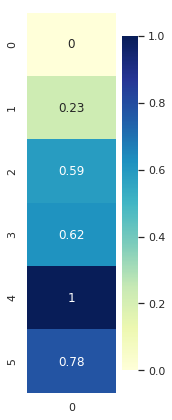

In [37]:
sns.set(rc={'figure.figsize':(2.0,7.0)})
sns.heatmap(df_h_s_attended_vector, annot=True, cmap='YlGnBu', )

# Between Sentences

In [38]:
model_s1 = Model(model.inputs,model.get_layer(name='sa1').output)
model_s2 = Model(model.inputs,model.get_layer(name='sa2').output)
model_s3 = Model(model.inputs,model.get_layer(name='sa3').output)
model_s4 = Model(model.inputs,model.get_layer(name='sa4').output)
model_s1.summary()
model_s2.summary()
model_s3.summary()
model_s4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_vectors (InputLayer (None, 500, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 16)           14416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           1568      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 32)           128       
_________________________________________________________________
sa1 (SelfAttention)          [(None, 500, 32), (500, 5 2377      
Total para

In [39]:
_, sb1, sg1 = model_s1.predict([x['sentence_vectors'],x['input_headline_vector']])
_, sb2, sg2 = model_s2.predict(x)
_, sb3, sg3 = model_s3.predict(x)
_, sb4, sg4 = model_s4.predict(x)

In [40]:
sg1,sg2, sg3, sg4

(array([0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128,
        0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128,
        0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128,
        0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128,
        0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128,
        0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128,
        0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128,
        0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128, 0.0050128,
        0.0050128, 0.0050128], dtype=float32),
 array([-0.01164258, -0.01164258, -0.01164258, -0.01164258, -0.01164258,
        -0.01164258, -0.01164258, -0.01164258, -0.01164258, -0.01164258,
        -0.01164258, -0.01164258, -0.01164258, -0.01164258, -0.01164258,
        -0.01164258, -0.01164258, -0.01164258, -0.01164258, -0.01164258,
        -0.01164258, -0.01164258, -0.01164258, -0.01164258, -0.011642

In [41]:
sb = sb1[test_idx]+sb2[test_idx]+sb3[test_idx]+sb4[test_idx]
sb = sb[:len(x['sentences'][test_idx]),:len(x['sentences'][test_idx])]

sb.shape

(6, 6)

In [42]:
df_sb = pd.DataFrame(sb)


zx = df_sb.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
zx_scaled = min_max_scaler.fit_transform(zx)
df_sb = pd.DataFrame(zx_scaled)

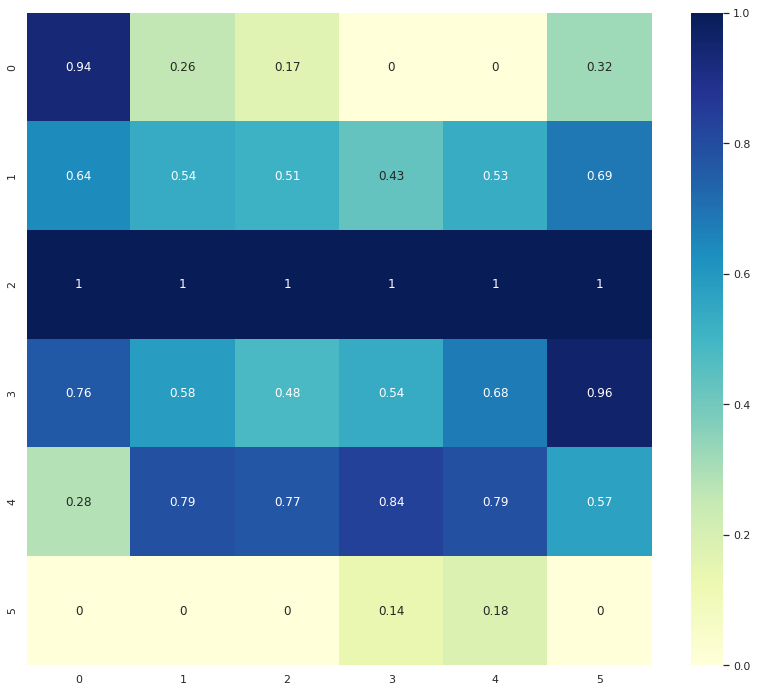

In [43]:
sns.set(rc={'figure.figsize':(14.0,12.0)})
sns.heatmap(pd.DataFrame(df_sb),annot=True,cmap='YlGnBu')

In [44]:
pd.DataFrame(x['sentences'][test_idx])

,0
0,"In a new interview with Britain’s Sky News, former NATO Secretary-General Anders Fogh Rasmussen brought out the old narrative of America as the “world’s policeman,” but with a lot more upbeat of an attitude about it than one would generally see."
1,"Rasmussen criticized President Obama for not being hawkish enough, saying his successor needs to be much more interventionist, and declaring “ we need America as the world’s policeman, ” adding that the US needs to “restore international law and order” through wars."
2,"Rasmussen, who was always a relative hawk in the post but seems to have taken it to an entirely new level, set out a series of things the US needs to fix militarily, including Iraq, Syria, Libya, Russia, China, and North Korea."
3,This of course closely mirrors recent Pentagon talk of wars in the decades to come.
4,"The timing of his calls for extreme US bellicosity are centered on trying to influence the upcoming US election in favor of Democratic nominee Hillary Clinton, who has campaigned heavily on picking fights in Syria and against Russia."
5,"Rasmussen underscored this fact by declaring Donald Trump, who openly said the US cannot be the world’s police, as “very dangerous for the world.”"


In [45]:

def datagen_dnf_eval():

    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]

    for idx in dnf_eval.id: 
        hd = dnf_eval[dnf_eval.id==idx]['headline'].values[0].lower()
        ar_id = dnf_eval[dnf_eval.id==idx]['id'].values[0]
        cl = dnf_eval[dnf_eval.id==idx]['claim_ids'].values[0]
        ar_claims.append(cl)
        sentences = articles[ar_id]
        vectors = article_vectors[ar_id]


        hds.append(hd)
        ar_sentences.append(sentences)
    #         print(len(sentences))
        sents = np.zeros((max_sentences,300))

        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))

        inputs = {
            'article_id': np.array(ar_ids)
            ,'headline': np.array(hds)
            ,'sentence_vectors' : np.array(ar_sents)
            ,'input_headline_vector': np.array(ar_head_vectors)
            ,'claims':np.array(ar_claims)
            ,'sentences':np.array(ar_sentences)
        }
        outputs = {
            'headline_token_classes': np.array(ar_head_classes)
            ,'output_headline_vector': np.array(ar_head_vectors)
        }
    return inputs,outputs
testX,testY = datagen_dnf_eval()

In [46]:

best_N = 5
_, b1, g1 = model_1.predict(testX)
_, b2, g2 = model_2.predict(testX)
_, b3, g3 = model_3.predict(testX)
_, b4, g4 = model_4.predict(testX)
ps, rs = [],[]
counter=0
for test_idx in range(len(testX['headline'])):    
    tp,fp,fn = 0,0,0
    claims = np.array(testX['claims'][test_idx])
#     sentences = list(range(len(articles[test_idx])))
    b = b1[test_idx]+b2[test_idx]+b3[test_idx]+b4[test_idx]
    pred = b[0][:len(testX['sentences'][test_idx])].argsort()[-best_N:][::-1]
    
#     print('claims:',claims)
#     print('pred:',pred)
    for p in pred:
        if p in claims:
            tp+=1
        else:
            fp+=1
    for c in claims:
        if c not in pred:
            fn+=1
    p = tp/(tp+fp)
    r = tp/(tp+fn)
#     print()
#     tn = sentences - list(set(list(pred)+list(claims)))
#     print(test_idx,', article id:',x['article_id'][test_idx], ',# sentences:',len(articles[x['article_id'][test_idx]]),":",p,r)
    ps.append(p)
    rs.append(r)
#     counter+=1
#     if counter==5:
#         break
#     print("----------------------------")
#     for s in t:
#         if s>=len(x['sentences'][test_idx]):continue
#         x['sentences'][test_idx][s]
np.average(ps), np.average(rs), 2*np.average(ps)*np.average(rs)/(np.average(ps)+ np.average(rs))

(0.389, 0.526, 0.44724371584699457)

In [47]:
df_hd_tp_cdc = pd.read_csv('evaluation_set/cdc_ibm/headline_topic_mapping.csv')
df_ar_cl_cdc = pd.read_csv('evaluation_set/cdc_ibm/article_claim_mapping.csv')
df_hd_tp_dnf = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V4.json')
df_hd_tp_dnf.columns = ['authors','claim_ids', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls']
with open('evaluation_set/cdc_ibm/articles.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/cdc_ibm/article_vectors.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
df_hd_tp_cdc.keys(),df_ar_cl_cdc.keys(), len(articles.keys()), len(article_vectors.keys()), df_hd_tp_dnf.keys()

(Index(['Topic', 'Title', 'article Id', 'Headline'], dtype='object'),
 Index(['Unnamed: 0', 'Topic', 'Article', 'Claim'], dtype='object'),
 522,
 522,
 Index(['authors', 'claim_ids', 'evidence', 'headline', 'id', 'reason',
        'claims', 'type', 'urls'],
       dtype='object'))

In [48]:
test_titles = []
for ar in df_ar_cl_cdc.Article.unique():
    if len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values)>8:
        test_titles.append(ar)

In [49]:
ar_ids,ar_sents,ar_sentences,ar_head_vectors,ar_head_classes,hds,claims=[],[],[],[],[],[],[]
for idx in tqdm_notebook(test_titles):
    print(idx)
    hd = df_hd_tp_cdc[df_hd_tp_cdc.Title==idx]['Headline'].values[0].lower()
    hds.append(hd)
    ar_id = df_hd_tp_cdc[df_hd_tp_cdc.Title==idx]['article Id'].values[0]
    cl = df_ar_cl_cdc[df_ar_cl_cdc.Article==idx]['Claim'].values
    claims.append(cl)
#     sentences=articles[ar_id]
#     ar_sentences.append(ar_sentences)
    #         print(len(sentences))
    sents = np.zeros((max_sentences,300))
    vectors = article_vectors[ar_id]
    sents[:len(vectors)] = vectors[:max_sentences]
    ar_ids.append(ar_id)
    ar_sents.append(sents)
    hd_nlp = nlp(hd.lower())
    head_classes = np.zeros(50, dtype='int')
    for i in range(len(hd_nlp)):
        head_classes[i] = hd_nlp[i].rank
    ar_head_vectors.append(hd_nlp.vector)
    ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
inputs = {
    'article_id': np.array(ar_ids)
    ,'headline': np.array(hds)
    ,'sentence_vectors' : np.array(ar_sents)
#     ,'sentences' : np.array(ar_sentences)
    ,'input_headline_vector': np.array(ar_head_vectors)
    ,'claims':np.array(claims)
}
outputs = {
    'headline_token_classes': np.array(ar_head_classes)
    ,'output_headline_vector': np.array(ar_head_vectors)
}

Video game controversies
Brown v. Entertainment Merchants Association
One-child policy
Human population control
Use of performance-enhancing drugs in sport
Physical exercise
Affirmative action
Equal opportunity
Affirmative action in the United States
Boxing
Multiculturalism in the Netherlands
Criticism of multiculturalism
Multicultural education
Gambling
Problem gambling
Economics of gambling
Republicanism in the United Kingdom
Nuclear weapon
Nuclear proliferation
Nuclear peace
Deterrence theory
Abortion debate
Philosophical aspects of the abortion debate
Year-round school
Social safety net
Poverty reduction
Economic inequality
Redistribution of wealth
Atheism
Existence of God
Criticism of religion
The God Delusion
Conscription
Aid effectiveness
Development aid
Aid
Care work
Intellectual property
Libertarian perspectives on intellectual property
Anti-copyright
Philosophy of copyright
Environmental impact of wind power
Biodiversity
Deficit spending
Gun control
Gun politics
Political arg

In [51]:
threshold = 0.95
best_N = 5
_, b1, g1 = model_1.predict(inputs)
_, b2, g2 = model_2.predict(inputs)
_, b3, g3 = model_3.predict(inputs)
_, b4, g4 = model_4.predict(inputs)
ps, rs = [],[]
counter=0
for test_idx in tqdm_notebook(range(len(inputs['headline']))):    
    tp,fp,fn = 0,0,0
    claims = np.array(inputs['claims'][test_idx])
#     sentences = list(range(len(articles[test_idx])))
    b = b1[test_idx]+b2[test_idx]+b3[test_idx]+b4[test_idx]
    ids = b[0][:len(articles[inputs['article_id'][test_idx]])].argsort()[-best_N:][::-1]
#     print(ids)
    pred = np.array(articles[inputs['article_id'][test_idx]])[ids]
#     print('claims:',claims)
#     print('pred:',pred)
    for i in range(len(pred)):
    #     print('===========***********',i,'***********============')
        t5 = nlp(str(pred[i]))
        flag = False
        #pred_claim_sent.append(pred[i])
    #     print(t5.vector)
        for j in range(len(cl)):
            _c = nlp(cl[j])
    #         print(_c.vector)
    #         print('top_5:',t5.text)
    #         print('-------------------')
    #         print('ground_truth:',_c.text)
    #         print('t5:{0}, cl:{1}, sim: {2}'.format(i,j,np.around(t5.similarity(_c),4)))
    #         print('===================================================================')
            if np.around(t5.similarity(_c),4) > threshold:
                tp+=1
                flag = True
                break
        if flag is False:
            fp+=1
        
            
   
    #     print(t5.vector)
    for j in range(len(cl)):
        _c = nlp(cl[j])
        flag = False
        for i in range(len(pred)):
    #     print('===========***********',i,'***********============')
            t5 = nlp(str(pred[i]))
        
    #         print(_c.vector)
    #         print('top_5:',t5.text)
    #         print('-------------------')
    #         print('ground_truth:',_c.text)
    #         print('t5:{0}, cl:{1}, sim: {2}'.format(i,j,np.around(t5.similarity(_c),4)))
    #         print('===================================================================')
            if np.around(t5.similarity(_c),4) > threshold:
                flag = True
                break
        if flag is False:
            fn+=1
         
    p = tp/(tp+fp)
    r = tp/(tp+fn)
#     print()
#     tn = sentences - list(set(list(pred)+list(claims)))
#     print(test_idx,', article id:',x['article_id'][test_idx], ',# sentences:',len(articles[x['article_id'][test_idx]]),":",p,r)
    ps.append(p)
    rs.append(r)

np.average(ps), np.average(rs), 2*np.average(ps)*np.average(rs)/(np.average(ps)+ np.average(rs))

(0.1872340425531915, 0.07724237937003894, 0.10936629315166427)